# Clean data

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn import manifold, preprocessing
import warnings

In [2]:
warnings.filterwarnings('ignore')
# Grab the qualtrics output
qual_output = [i for i in os.listdir('input_data/') if i.startswith('RK')][0]

# Prep responses and key
raw = pd.read_csv(os.getcwd()+'/input_data/'+qual_output)
raw_reorg = raw.drop(axis='index',index=[0,1])
raw_reorg['subject'] = list(raw_reorg.index)
raw_reorg = raw_reorg.reset_index(drop=True)
raw_reorg['Duration (in seconds)'] = pd.to_numeric(raw_reorg['Duration (in seconds)'])
key = pd.read_csv('input_data/qualtrics_question_key.csv')

responses = raw_reorg
responses['subject'] = list(raw_reorg.index)
responses = responses.loc[:, responses.columns.str.startswith('Q')]
responses = responses[responses.columns[1:-7]]

# Get total number of responses
print("Total number of responses from qualtrics - "+str(len(responses)))

Total number of responses from qualtrics - 1065


In [3]:
filter_col = [col for col in raw if col.startswith('Q8.2')]
relationships = pd.read_csv('input_data/159relationships_fix_label.csv',index_col=0)
relationships = relationships.iloc[:,0].to_list()

dimensions = key['dimension'].tolist()[2:-3]
dimensions = [i.replace('Importance for individuals involved','Importance for individuals') for i in dimensions]
dimensions = [i.replace('/','_') for i in dimensions]

dimension_frames = {}
count=2
for dim in dimensions:  # exclude foil and demographics
    filtered_cols = [col for col in raw_reorg if col.startswith('Q'+str(key['block'].iloc[count])+'.2')]
    dimension_frames[dim] = pd.DataFrame(responses[filtered_cols])
    dimension_frames[dim].columns = relationships
#     dimension_frames[dim] = fix_df_labels(dimension_frames[dim])
    count=count+1

print("Total number of relationships - " + str(len(dimension_frames[dim].columns)))
print("Total number of dimensions - " + str(len(dimensions)))

Total number of relationships - 159
Total number of dimensions - 30


In [4]:
# Check color foils to exclude people
foil_items = [x for x in raw.columns.tolist() if x.startswith('Q2.1')]
foil_items = foil_items + [x for x in raw.columns.tolist() if x.startswith('Q35.1')]
foil_items = raw[foil_items].iloc[0]
foil_items = [s.replace('\xe2\x80\x93', '-') for s in foil_items]
foil_items = [i.split(' - ', 1)[1] for i in foil_items]
filtered_cols = [col for col in raw_reorg if col.startswith(('Q2.1','Q35.1'))]
foils_color_size = pd.DataFrame(responses[filtered_cols])
foils_color_size.columns = foil_items
foils_color_size['MTurkCode']  =raw_reorg['MTurkCode']
foils_color_size = foils_color_size.apply(pd.to_numeric)
"""foils = all_resp_melt.loc[all_resp_melt['word'].isin(['Movie','Fire','Jackpot',
                                                      'Deathbed','Car'])]
foils_melt = all_resp_melt.loc[all_resp_melt['word'].isin(['Movie','Fire','Jackpot',
                                                      'Deathbed','Car'])]"""
foils_color_size_melt = pd.melt(foils_color_size, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_color_size_list = []
for col in foils_color_size.columns[:-1]:
    outliers_color_size_list = outliers_color_size_list + list(foils_color_size[(foils_color_size[col] > 
                   foils_color_size[col].mean()+foils_color_size[col].std()*3.5) |
                   (foils_color_size[col] < 
                    foils_color_size[col].mean()-foils_color_size[col].std()*3.5)].index)
outliers_color_size_list = set(outliers_color_size_list)

# Remove outliers based on assumptions of words
# Frequency of deathbed > car
# Removing subjects based on completetion time is not the best (they do okay)
foil_color_size_outliers = foils_color_size
foil_color_size_outliers = foil_color_size_outliers[~foil_color_size_outliers.index.isin(outliers_color_size_list)]
foil_color_size_outliers_melt = pd.melt(foil_color_size_outliers, id_vars='MTurkCode')

# Check foils to see if any subjs responded indiscriminately
foil_relationships = [x for x in raw.iloc[0].tolist() if x.startswith('Q34')]
foil_relationships = [x[6:] for x in foil_relationships]
foil_relationships = [x for x in raw.columns.tolist() if x.startswith('Q34.1')]
foil_relationships = raw[foil_relationships].iloc[0]
foil_relationships = [s.replace('\xe2\x80\x93', '-') for s in foil_relationships]
foil_relationships = [i.split(' - ', 1)[1] for i in foil_relationships]
filtered_cols = [col for col in raw_reorg if col.startswith('Q34.1')]
foils = pd.DataFrame(responses[filtered_cols])
foils.columns = foil_relationships
foils['MTurkCode']  =raw_reorg['MTurkCode']
foils = foils.apply(pd.to_numeric)
foils_melt = pd.melt(foils, id_vars='MTurkCode')

# Check for values above means for unexpected foils
outliers_list = []
for rel in foils.columns[:-1]:
    outliers_list = outliers_list + list(foils[(foils[rel] > 
                   foils[rel].mean()+foils[rel].std()*2) |
                   (foils[rel] < 
                    foils[rel].mean()-foils[rel].std()*2)].index)
outliers_list = set(outliers_list)

# Remove outliers based on assumptions of words
foil_outliers = foils
foil_outliers = foil_outliers[~foil_outliers.index.isin(outliers_list)]
foil_outliers_melt = pd.melt(foil_outliers, id_vars='MTurkCode')

# Remove relationship ratings where subjects indicated that they did not 
# understand the relationships
filtered_cols = [col for col in raw_reorg if col.startswith(('Q3.1'))]
familiarity = pd.DataFrame(raw_reorg[filtered_cols])
familiarity.columns = relationships
familiarity['MTurkCode'] = raw_reorg['MTurkCode']
familiarity = familiarity.apply(pd.to_numeric)
familiarity_melt = pd.melt(familiarity, id_vars='MTurkCode')

# Check for values above means for unexpected foils
familiarity_list = []
for col in familiarity.columns[:-1]:
    familiarity_list = familiarity_list + list(familiarity[(familiarity[col] < 
                    familiarity[col].mean()-familiarity[col].std()*3.5)].index)
familiarity_list = set(familiarity_list)

In [5]:
# Remove outliers from the rest of the data
outliers_all_list = set(list(outliers_list) + list(outliers_color_size_list) + list(familiarity_list))
dimension_frames_outliers = dimension_frames.copy()
for dim in dimension_frames_outliers:
    dimension_frames_outliers[dim] = dimension_frames[dim][~dimension_frames[dim].index.isin(outliers_all_list)]
    dimension_frames_outliers[dim] = dimension_frames_outliers[dim].apply(pd.to_numeric)

# Check total number of responses for each word with outliers excluded
num_response_outliers = pd.DataFrame(index=relationships,columns=dimensions)
for dim in dimensions:
    num_response_outliers[dim] = dimension_frames_outliers[dim].count() 

print("Total number of responses, excluding bad participants - "+str(len(dimension_frames_outliers[dim])))
print("Smallest number of ratings for a relationship - " + str(min(list(num_response_outliers.min()))))
print("Largest number of ratings for a relationship - " + str(max(list(num_response_outliers.max()))))

Total number of responses, excluding bad participants - 817
Smallest number of ratings for a relationship - 4
Largest number of ratings for a relationship - 30


## Demographics

In [6]:
filtered_demo = [col for col in raw_reorg if col.startswith('Q36')]
response_demographic = raw_reorg.loc[:,filtered_demo]
response_demographic = response_demographic[~response_demographic.index.isin(outliers_all_list)]
response_demographic.columns = ['Age','Gender','Race','Ethnicity',
                                'Highest education','First language','First language alternative']
response_demographic.head()

,Age,Gender,Race,Ethnicity,Highest education,First language,First language alternative
0,35 - 44,Male,White,Not Hispanic or Latino,4 year degree,Yes,NaN
1,18 - 24,Male,White,Not Hispanic or Latino,4 year degree,Yes,NaN
2,18 - 24,Female,White,Not Hispanic or Latino,4 year degree,Yes,NaN
3,45 - 54,Male,White,Not Hispanic or Latino,4 year degree,Yes,NaN
4,25 - 34,Female,White,Not Hispanic or Latino,Professional degree,Yes,NaN


### Gender

In [7]:
response_demographic['Gender'][response_demographic['Gender'].isna()] = 'No response'
response_demographic['Gender'].value_counts()

Female                  480
Male                    300
No response              33
Prefer not to answer      4
Name: Gender, dtype: int64

### Age

In [8]:
response_demographic['Age'][response_demographic['Age'].isna()] = 'No response'
response_demographic['Age'].value_counts()

25 - 34        318
35 - 44        186
18 - 24        108
45 - 54         97
55 - 64         53
No response     33
65 - 74         20
75 - 84          2
Name: Age, dtype: int64

### Race

In [9]:
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'][response_demographic['Race'].isna()] = 'No response'
response_demographic['Race'].value_counts()

White                                  652
Black or African American               68
No response                             33
Asian                                   30
Other                                   26
American Indian or Alaska Native         6
Native Hawaiian or Pacific Islander      2
Name: Race, dtype: int64

### Highest education

In [10]:
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'][response_demographic['Highest education'].isna()] = 'No response'
response_demographic['Highest education'].value_counts()

4 year degree            299
Some college             182
Professional degree      115
2 year degree             88
High school graduate      85
No response               33
Doctorate                 13
Less than high school      2
Name: Highest education, dtype: int64

### First language

In [11]:
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'][response_demographic['First language'].isna()] = 'No response'
response_demographic['First language'].value_counts()

Yes            784
No response     33
Name: First language, dtype: int64

## Heatmap

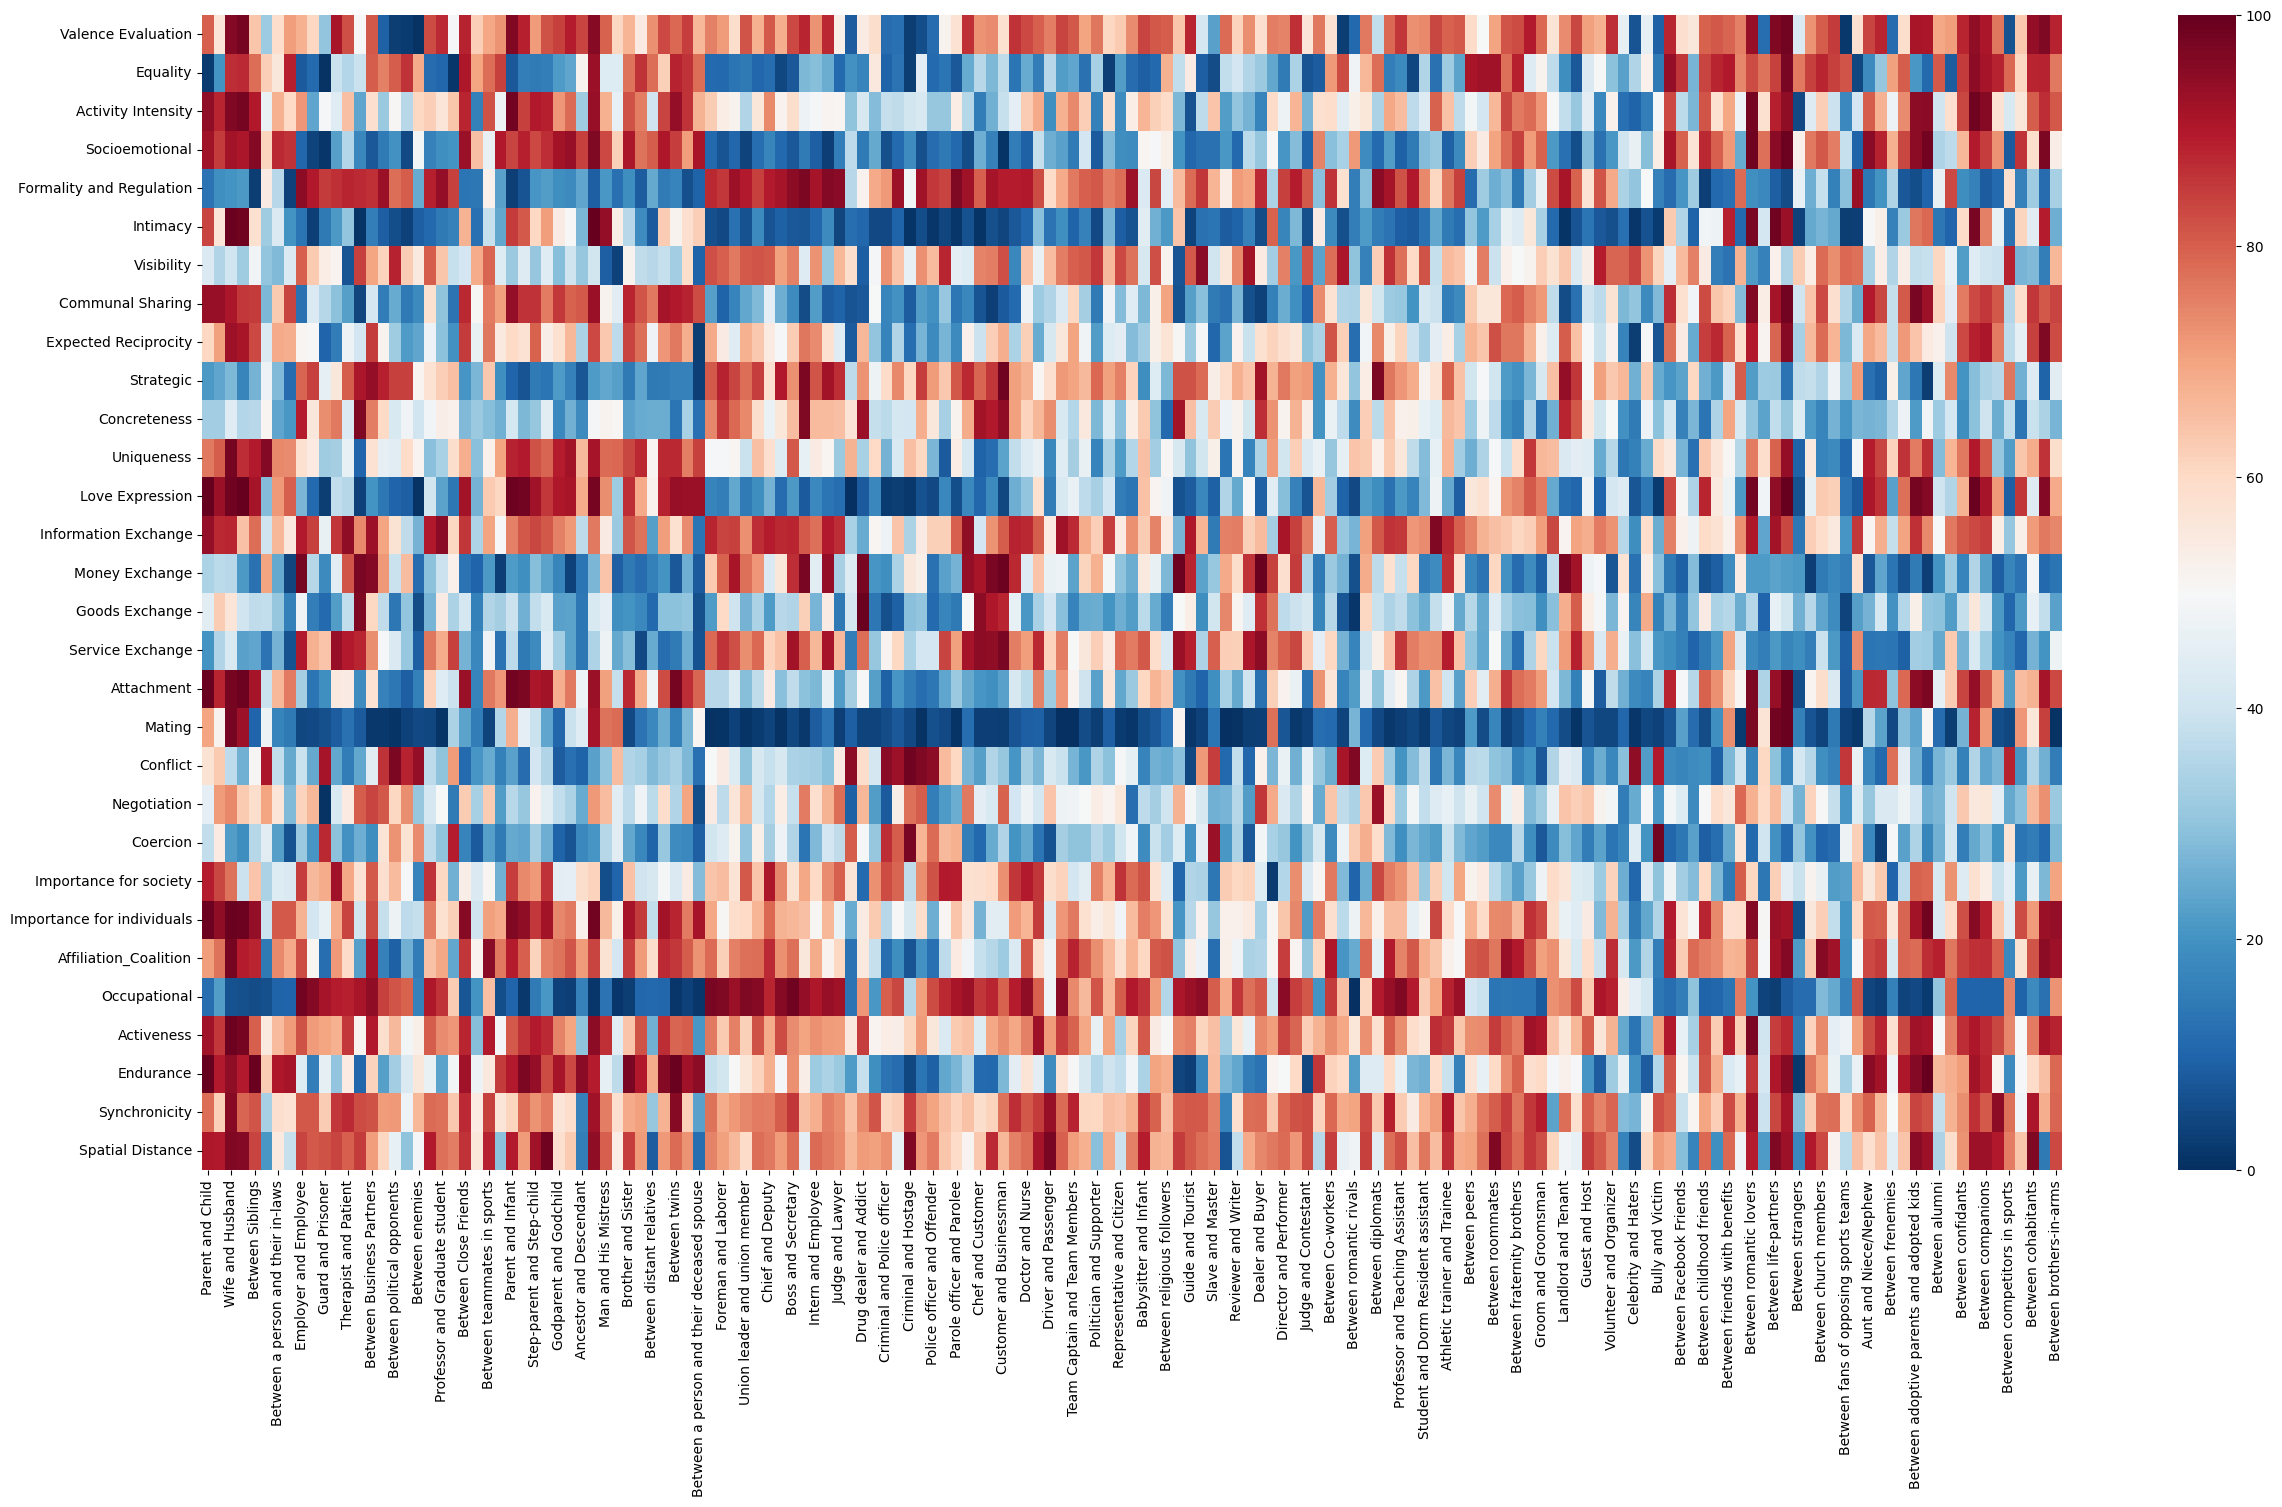

In [12]:
dim_rel = pd.DataFrame(columns = relationships)
count=0
for dim in dimensions:
    dim_rel.loc[count] = dimension_frames_outliers[dim].mean().tolist()
    count = count + 1
dim_rel.index = dimensions
dim_rel.to_csv('output_data/cleaning_results/USA_dim_rel_30d.csv')

plt.figure(figsize=(30,15))
sns.heatmap(dim_rel, center=50,cmap="RdBu_r")

dim_rel_scaled = preprocessing.scale(dim_rel.transpose())
dim_rel_scaled = pd.DataFrame(dim_rel_scaled,index=dim_rel.columns,columns=dim_rel.index)
dim_rel_scaled.to_csv('output_data/cleaning_results/USA_dim_rel_scaled_30d.csv')

# PCA

In [2]:
library(FactoMineR)
library(factoextra)#fviz_eig
library(psych)

library(ggplot2)
library(corrplot)
library(RColorBrewer)

library(tidyverse)
library(reshape)#melt
library(nFactors)#optimal number of components

## optimal dimensions
plotnScree:https://rdrr.io/cran/nFactors/src/R/plotnScree.R

In [33]:
plotnScree <-
function (nScree,
          elbow = 3,
          legend = TRUE,
          ylab   = "Eigenvalues",
          xlab   = "Components",
          main   = "Non Graphical Solutions to Scree Test")
          {
   if (!inherits(nScree, "nScree"))  stop("Method is only for nScree objects")
   #if (!exists("legend", mode="logical") ) legend <- TRUE                                   # To develop
   #if (!exists("ylab"))                    ylab <- "Eigenvalues"                            # To develop
   #if (!exists("xlab"))                    xlab <- "Components"                             # To develop
   #if (!exists("main"))                    main <- "Non Graphical Solutions to Scree Test"  # To develop
   if (nScree$Model == "components") nkaiser = "Eigenvalues (>mean  = " else nkaiser = "Eigenvalues (>0 = "
   if (nScree$Model == "factors")  xlab   = "Factors"
   par(col   = 1, pch = 1)     # Color and symbol for usual scree
   par(mfrow = c(1,1),lwd=2)
   eig        <- nScree$Analysis$Eigenvalues
   k          <- 1:length(eig)
   #plotuScree(x=eig, ...)                                                                   # To develop
   plotuScree(x=eig, main=main, xlab=xlab, ylab=ylab)
   nk         <- length(eig)
   noc        <- nScree$Components$noc
   vp.p       <- lm(eig[c(noc+1,nk)] ~ k[c(noc+1,nk)])
   x          <- sum(c(1,1) * coef(vp.p))
   y          <- sum(c(1,nk)* coef(vp.p))
   par(col = 10)            # Color for optimal coordinates
   lines(k[c(1,nk)],c(x,y),lwd=1.8)
   par(col = 11,pch=2)            # Color and symbol for parallel analysis
   lines(1:nk, nScree$Analysis$Par.Analysis, type = "b",lwd=1.8)
   if (legend == TRUE) {
     leg.txt  <- c(paste("Parallel Analysis (n = ",nScree$Components$nparallel,")"),
                 c(paste("Kaiser-Guttman rule (n = ",nScree$Components$nkaiser,")")),
                 c(paste("Cattell’s scree test (n = ",elbow,")")),
                 c(paste("Optimal Coordinates (n = ",nScree$Components$noc,")")) )
     legend("topright",
            legend   = leg.txt,
            pch      = c('△','_','○','_'),
            text.col = c(3,4,1,2), 
            col = c(3,4,1,2),
            cex = 1.3)
     }
   naf        <-   nScree$Components$naf
   text(x = noc ,    y = eig[noc],     label = " (OC)", cex = 1, adj = c(0,0), col = 2)
#    text(x = naf + 1, y = eig[naf + 1], label = " (AF)", cex = .70, adj = c(0,0), col = 4)
   }

In [34]:
# import relationship dimension ratings scaled from the Data cleaning's output
dim_rel_scaled = read.csv('output_data/cleaning_results/USA_dim_rel_scaled_30d.csv', row.names=1,encoding='UTF-8')

# Parallel analysis, Optimal Coordinates, and  Cattell's Scree Test
ev <- eigen(cor(dim_rel_scaled)) # get eigenvalues
ap <- parallel(subject=nrow(dim_rel_scaled),var=ncol(dim_rel_scaled),model="components",rep=5000,cent=.05) 
nS <- nScree(x=ev$values, model = "components",aparallel=ap$eigen$qevpea) # "qevpea" indicate 95 centile given cent=.05 

In [35]:
nS$Analysis$Cumu[1:5]

[1] 0.4276719 0.6231035 0.7010401 0.7745254 0.8214303

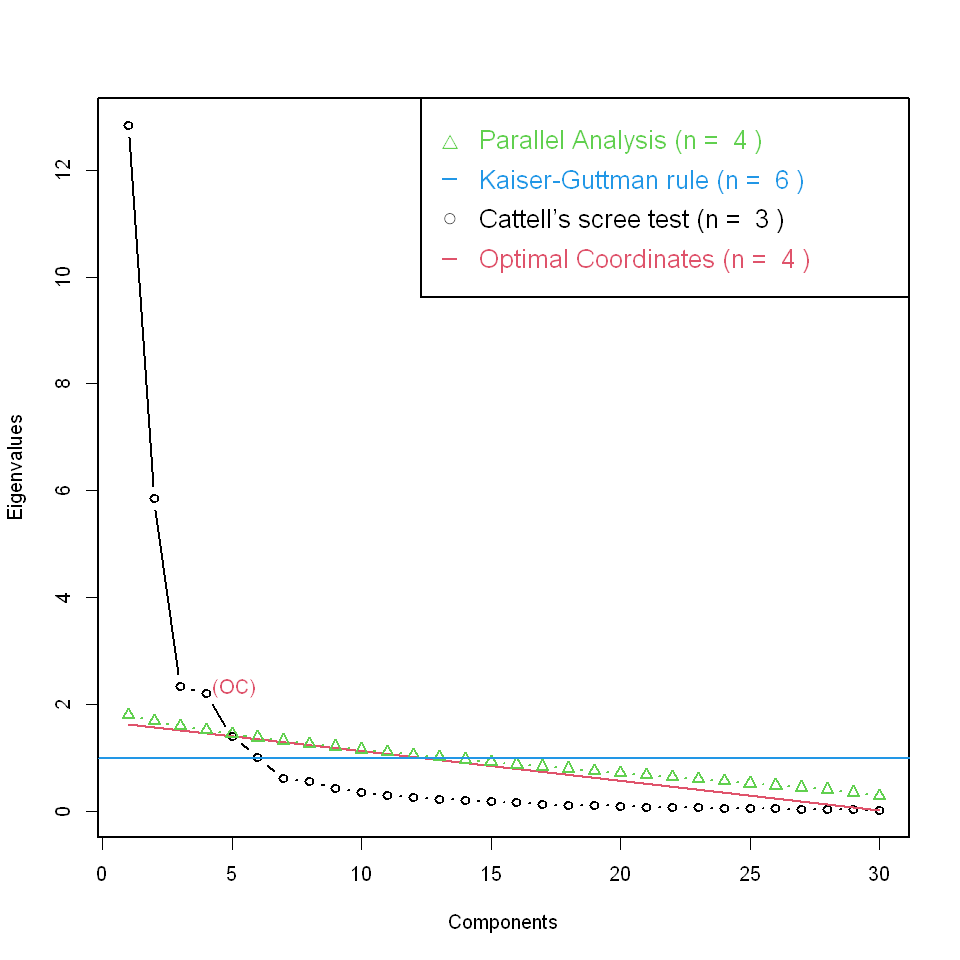

In [37]:
options(repr.plot.width=8,repr.plot.height=8)
plotnScree(nS, elbow = 3,legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule

In [38]:
png("output_graph/optimal_components.png",
    family = 'sans',units='in',width=8,height=8,res=300)
plotnScree(nS,elbow = 3, legend=TRUE, main = NULL)
abline(h = 1, col=4, lty=1,lwd =1.8) # Kaiser-Guttman Rule
dev.off()

png 
  2

## loading score

In [4]:
dim_rel.pca = prcomp(dim_rel_scaled)
ncomp = 5

loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

loadings_var = varimax(loadings_none)$loadings
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat
loadings_var

write.csv(loadings_var,'output_data/pca_results/USA_loadings_var.csv')
write.csv(scores_var,'output_data/pca_results/USA_scores_var.csv')


Loadings:
                           [,1]   [,2]   [,3]   [,4]   [,5]  
Valence.Evaluation         -0.243  0.278 -0.858  0.152 -0.111
Equality                   -0.196        -0.153 -0.330  0.798
Activity.Intensity         -0.615  0.624 -0.239 -0.277       
Socioemotional             -0.736        -0.294 -0.488  0.262
Formality.and.Regulation    0.713  0.120  0.140  0.491 -0.347
Intimacy                   -0.830  0.270 -0.266 -0.134  0.155
Visibility                  0.836               -0.105       
Communal.Sharing           -0.543  0.233 -0.410 -0.616  0.203
Expected.Reciprocity       -0.273  0.490 -0.509         0.512
Strategic                   0.697         0.196  0.603       
Concreteness                0.229  0.152  0.131  0.844 -0.123
Uniqueness                 -0.756  0.357        -0.168       
Love.Expression            -0.665  0.228 -0.512 -0.407  0.106
Information.Exchange        0.158  0.680 -0.489  0.178 -0.218
Money.Exchange              0.246                0.887     

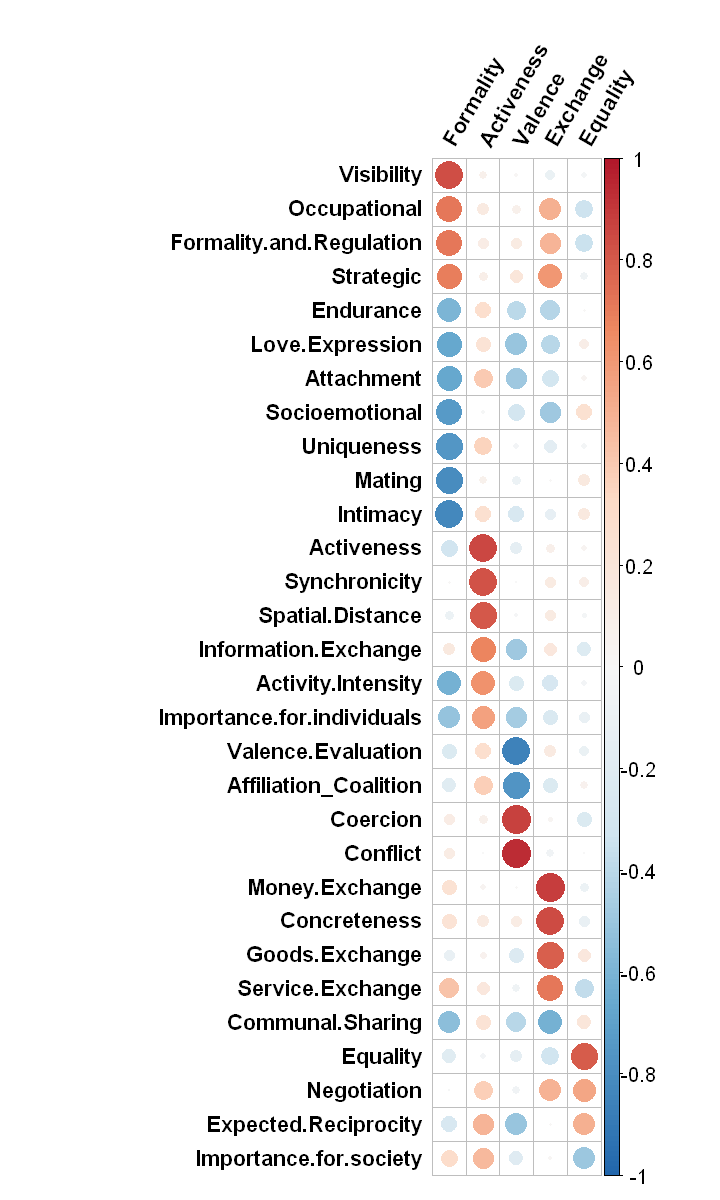

In [9]:
loadings_var_reorder = as.data.frame(loadings_var[,1:ncomp])
colnames(loadings_var_reorder) = c('Formality','Activeness','Valence','Exchange','Equality')

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:30)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(Formality))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(Activeness))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(Valence)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(Exchange))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(Equality))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=6, repr.plot.height=10)
my.breaks = c(seq(-1,1,by=0.01))
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(length(my.breaks)))

In [10]:
png("output_graph/study1_loading_bipolar.png", bg="transparent",
    family = 'sans',units='in',width=6,height=10,res=300)
colnames(loadings_var_reorder) = rep('',5)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         tl.col = "black",tl.srt=60,tl.cex=1.1,family='sans',font=2,
         col.lim = c(-1,1),cl.ratio = 0.4,cl.cex=1,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))
dev.off()

png 
  2

## relationships score

In [6]:
library(ggrepel)

### Formality-Activeness

In [7]:
fix_label = function(rels){
    rels = gsub(' and ','-',rels)
    rels = gsub(' – ','-',rels)
    rels = gsub('Between ','',rels)
    return(rels)
}

In [8]:
scores_var_plot = data.frame(scores_var)
colnames(scores_var_plot) = c('Formality','Activeness','Valence','Exchange','Equality')
scores_var_plot['Equality'] = -scores_var_plot['Equality']
scores_var_plot['Valence'] = -scores_var_plot['Valence']

scores_var_plot['rel'] = rownames(scores_var_plot)

In [9]:
show_rel_FA = c('Between Business Partners','Politician and Supporter',
            'Wife and Husband','Parent and Infant','Between Co-workers',
            'Between distant relatives',
            'Officer and Soldier','Between divorced spouses',
            'Between Siblings','Man and God','Between strangers')

show_rel_FA_df = scores_var_plot %>% filter(rel %in% show_rel_FA)

rel_fix = fix_label(show_rel_FA_df$'rel')
#rel_fix = gsub('twins','Twins',rel_fix)
rel_fix = gsub('strangers','Strangers',rel_fix)
rel_fix = gsub('divorced spouses','Divorced spouses',rel_fix)
rel_fix = gsub('soul-mates','Soul-mates',rel_fix)
rel_fix = gsub('distant','Distant',rel_fix)
show_rel_FA_df['rel'] = rel_fix

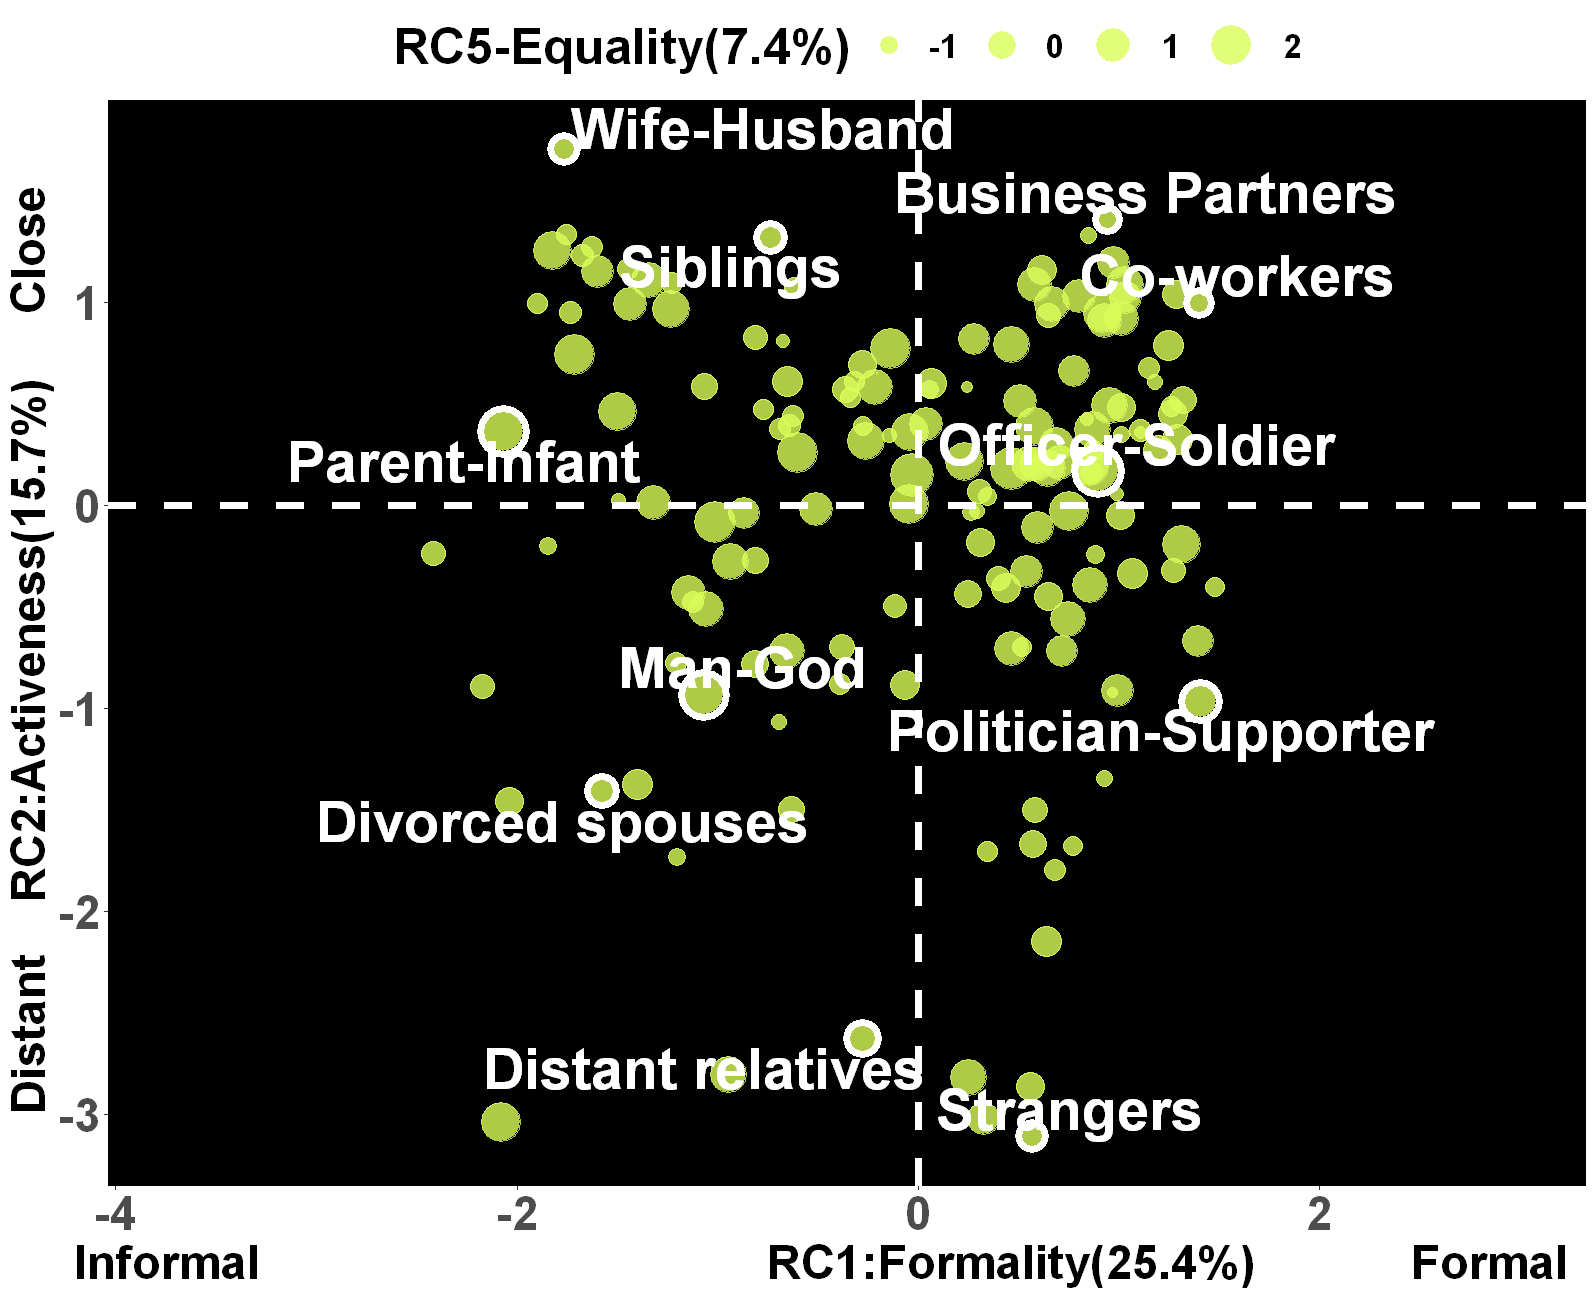

In [10]:
randomseed = 2022
options(repr.plot.height=10.82,repr.plot.width=13.3)
ggplot(scores_var_plot, aes(x=Formality,y=Activeness))+
geom_point(aes(size=Equality),color='#DAFD59',alpha=0.8)+
#scale_color_gradient(low = 'white',high = '#DAFD59')+
#guides(alpha=guide_legend(title = 'alpha:RC5:Equality(7.4%)'))+

geom_text_repel(data = show_rel_FA_df,
                mapping=aes(label=rel),size=12,
                seed = randomseed,
                fontface = 'bold',color='white',
                #family='',
                min.segment.length = Inf)+
geom_point(data = show_rel_FA_df,aes(size=Equality),color='white',
           shape=1,stroke=3)+
scale_size_continuous(range=c(0.1,12))+
#geom_rug(aes(color=Equality),color='#DAFD59')+

xlim(-3.7,3)+
xlab('           Informal                                       RC1:Formality(25.4%)            Formal               ')+
ylab('   Distant    RC2:Activeness(15.7%)     Close    ')+

geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
#ggtitle('USA_Study3')+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'), 
      axis.title.x=element_text(size=28,face='bold'),
      axis.title.y=element_text(size=28,face='bold'),
      axis.text=element_text(size=28,face='bold'),
      legend.title=element_text(face="bold",size=30),
      legend.position='top',#legend.key.height=unit(1,'cm')
      legend.text=element_text(face="bold",size=20))+
labs(size = 'RC5-Equality(7.4%)')

In [25]:
png("output_graph/study1_scatter_FA.png", bg="black",
     family = 'sans',units='in',width=13.3,height=10.82,res=300)
ggplot(scores_var_plot, aes(x=Formality,y=Activeness))+
geom_point(aes(size=Equality),color='#DAFD59',alpha=0.8)+
geom_point(data = show_rel_FA_df,aes(size=Equality),color='white',
           shape=1,stroke=3)+
scale_size_continuous(range=c(0.1,12))+
guides(size=guide_legend(title = ''))+

xlim(-3.7,3)+
# xlab('           Informal                                       RC1:Formality(25.4%)                       Formal               ')+
# ylab('   Inactive    RC2:Activeness(15.7%)     Active    ')+
xlab('')+
ylab('')+

geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+
#ggtitle('USA_Study3')+
theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'), 
      axis.line=element_line(color='white',size=2),
#       axis.title.x=element_text(size=45,face='bold',),
#       axis.title.y=element_text(size=45,face='bold'),
      axis.text=element_text(size=28,face='bold',color='white'),
#       legend.title=element_text(face="bold",size=45),
      legend.position='top',#legend.key.height=unit(1,'cm')
      legend.text=element_text(face="bold",size=20,color='white'),
      legend.background=element_rect(fill='black'),
      legend.key=element_rect(fill='black'),
      plot.background = element_rect(fill = 'black'))

dev.off()

png 
  2

### Valence-Exchange

In [13]:
show_rel_VE = c('Bully and Victim','Dealer and Buyer','Celebrity and Haters',
            'Reader and Writer','Slave and Master','Customer and Server',
            'Between ex-lovers','Between church members','Prostitute and Customer',
            'Between sports rivals','Brother and Sister','Between pen-friends')

show_rel_VE_df = scores_var_plot %>% filter(rel %in% show_rel_VE)

rel_fix = fix_label(show_rel_VE_df$'rel')
rel_fix = gsub('pen-friends','Pen-friends',rel_fix)
rel_fix = gsub('romantic','Romantic',rel_fix)
rel_fix = gsub('sports rivals','Sports rivals',rel_fix)
rel_fix = gsub('ex-lovers','Ex-lovers',rel_fix)
#rel_fix = gsub('close','Close',rel_fix)
rel_fix = gsub('church','Church',rel_fix)

show_rel_VE_df['rel'] = rel_fix

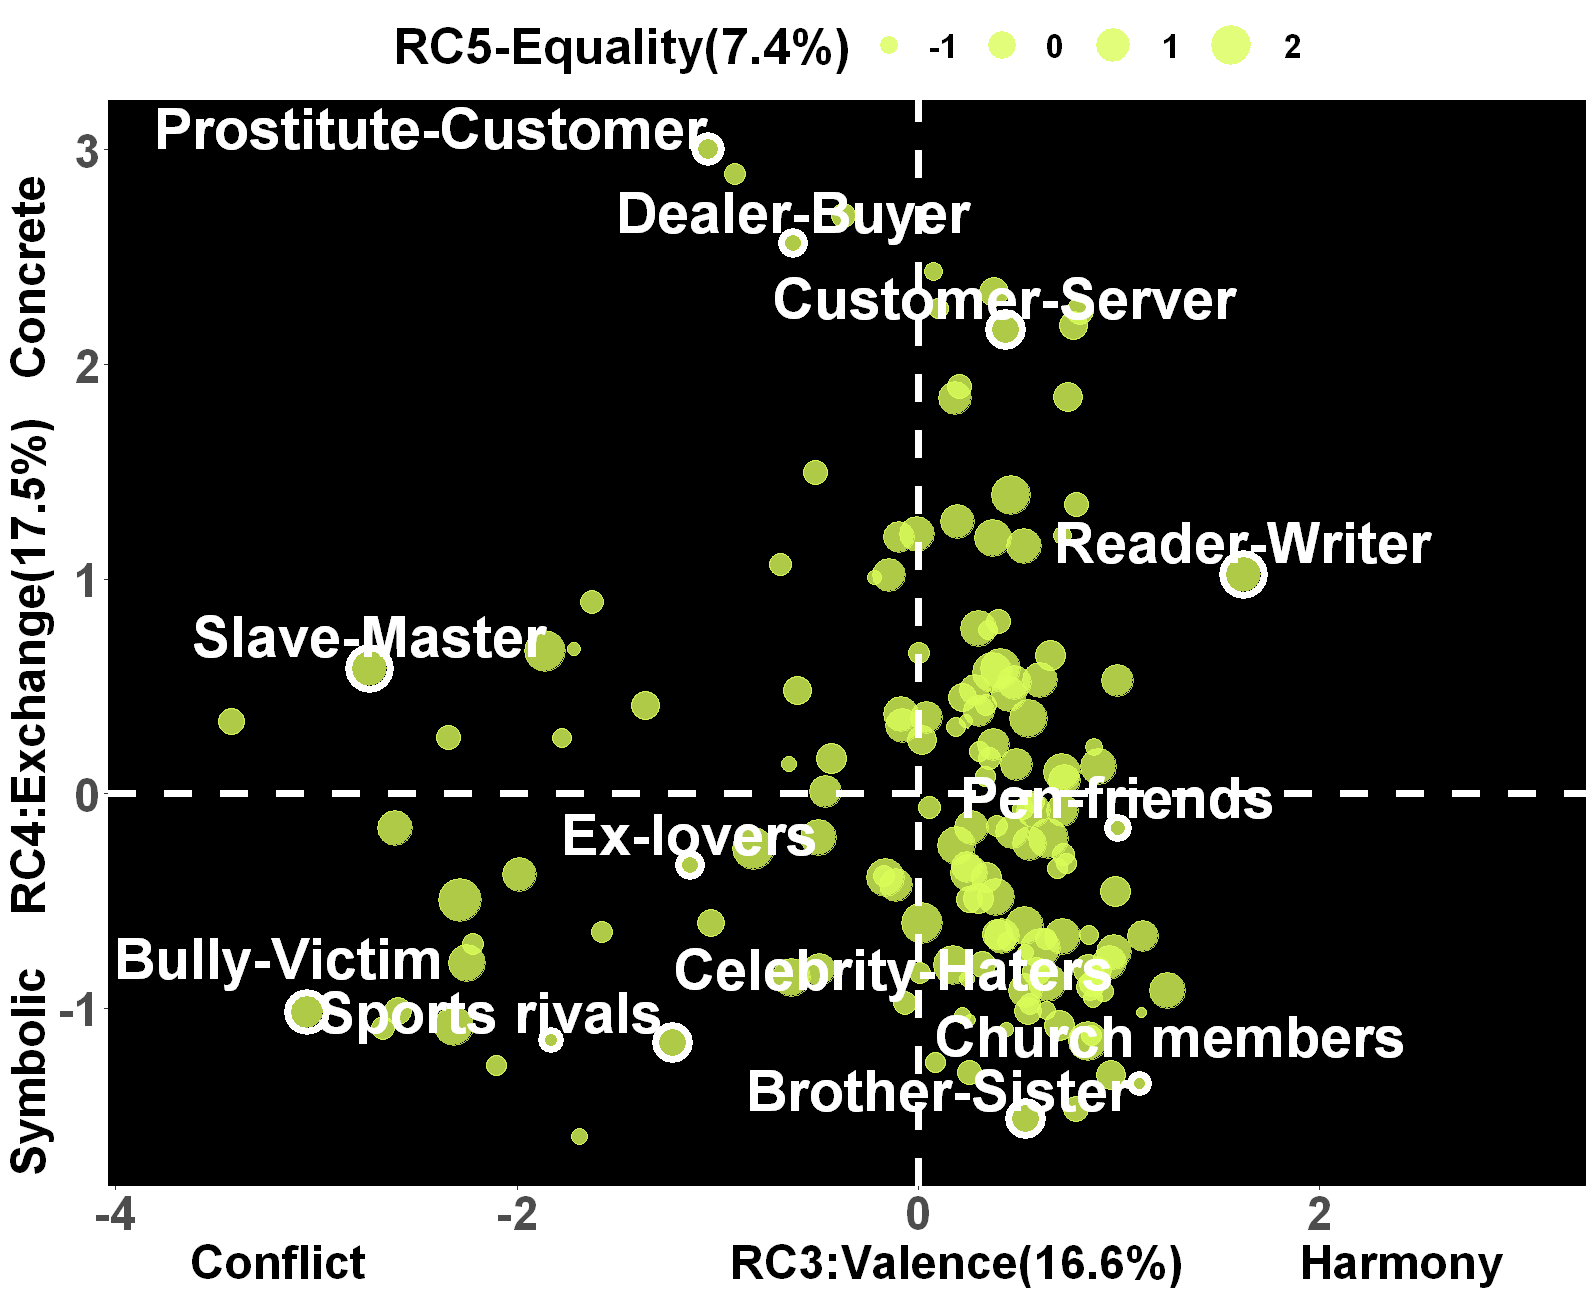

In [14]:
randomseed = 2022
options(repr.plot.height=10.82,repr.plot.width=13.3)
ggplot(scores_var_plot, aes(x=Valence,y=Exchange))+
geom_point(aes(size=Equality),color='#DAFD59',alpha=0.8)+
#scale_color_gradient(low = 'white',high = '#DAFD59')+
scale_size_continuous(range=c(0.1,12))+

geom_text_repel(data = show_rel_VE_df,
                mapping=aes(label=rel),size=12,
                seed = randomseed,
                fontface = 'bold',color='white',nudge_y=0.15,
                #family='',
                min.segment.length = Inf)+
geom_point(data = show_rel_VE_df,color='white',aes(size=Equality),
           shape=1,stroke=3)+
#geom_rug(aes(color=Equality),size=2)+

xlim(-3.7,3)+
xlab('Conflict                            RC3:Valence(16.6%)         Harmony')+
ylab('     Symbolic    RC4:Exchange(17.5%)   Concrete          ')+

geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+

theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'),
      axis.title.x=element_text(size=28,face='bold'),
      axis.title.y=element_text(size=28,face='bold'),
      axis.text=element_text(size=28,face='bold'),
      legend.title=element_text(face="bold",size=30),
      legend.position='top',
      legend.text=element_text(face="bold",size=20))+
labs(size = 'RC5-Equality(7.4%)',color='')

In [32]:
png("output_graph/study1_scatter_VE.png", bg="transparent",
    family = 'sans',units='in',width=13.3,height=10.82,res=300)

ggplot(scores_var_plot, aes(x=Valence,y=Exchange))+
geom_point(aes(size=Equality),color='#DAFD59',alpha=0.8)+
geom_point(data = show_rel_VE_df,color='white',aes(size=Equality),
           shape=1,stroke=3)+
scale_size_continuous(range=c(0.1,12))+

xlim(-3.7,3)+
# xlab('Negative                                          RC3:Valence(16.6%)                      Positive')+
# ylab('     Symbolic    RC4:Exchange(17.5%)   Concrete          ')+
xlab('')+
ylab('')+
geom_hline(yintercept = 0,linetype='dashed',size = 2,color='white')+
geom_vline(xintercept = 0,linetype='dashed',size = 2,color='white')+

theme_bw()+
theme(panel.border=element_blank(),panel.grid=element_blank(),
      panel.background = element_rect(fill = 'black'),
      axis.line=element_line(color='white',size=2),
#       axis.title.x=element_text(size=45,face='bold'),
#       axis.title.y=element_text(size=45,face='bold'),
      axis.text=element_text(size=28,face='bold',color='white'),
#       legend.title=element_text(face="bold",size=45),
      legend.position='top',
      legend.text=element_text(face="bold",size=20),
      legend.background=element_rect(fill='black'),
      legend.key=element_rect(fill='black'),
      plot.background=element_rect(fill='black'))

dev.off()

png 
  2